# Laboratorium 4
Piotr Kuchta, Sebastian Soczawa



Zadanie 1: wyznaczanie wielomianów interpolujących za pomocą: wielomianów Lagrange'a z równoodległymi węzłami, kubicznych funkcji sklejanych z równoodległymi węzłami oraz wielomianów Lagrange'a z węzłami Czebyszewa

Na początku importujemy potrzebne biblioteki

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import mpmath as mp
from random import uniform

Definiujemy podane w zadaniu funkcje:

In [48]:
def f1(x):
    return 1/(1+25*x*x)

def f2(x):
    return mp.exp(mp.cos(x))

Następnie implementujemy funkcję obliczającą wielomian interpolacyjny Lagrange'a

In [49]:
def lagrange_polynomial(x_values, y_values, x):
    sol = 0
    t = 0
    for i in range(0, len(x_values)):
        t = 1
        for j in range(0, len(y_values)):
            if(j != i):
                t = t*((x-x_values[j])/(x_values[i]-x_values[j]))
        sol += t*y_values[i]
    return sol

Oraz funkcje pomocnicze służące do generowania węzłów Czebyszewa

In [50]:
#transforms chebyshew points to interval [a,b]

def transform_cheb(nodes, a, b):
    for i in range(len(nodes)):
        nodes[i] = a+(b-a)*(nodes[i]+1)/2
    return nodes
#calculates n standard chebyshew points on interval[1,1]
  
def get_nodes_cheb(n):
    nodes = np.empty(shape=n, dtype=float)
    for i in range(n):
        nodes[i] = np.cos(np.pi*(2*i+1)/(2*n+2))
    return nodes

i funkcję do generowania równoodległych punktów

In [51]:
#gets n equidistant nodes in interval [a,b] 

def get_eqdist(n, a, b):
    nodes = np.empty(shape=n, dtype=float)
    h = (b-a)/n
    for i in range(n):
        nodes[i] = a+h*i        
    nodes[n-1] = b
    return nodes

Zadanie a)

Definiujemy węzły interpolacji oraz punkty próbkowania

In [52]:
# 12 interpolation nodes for Lagrange
x_eq = get_eqdist(12, -1, 1)
y_eq = [f1(x) for x in x_eq]
# 12 interpolation nodes for Chebyshew
x_ch = transform_cheb(get_nodes_cheb(12), -1, 1)
y_ch = [f1(x) for x in x_ch]
# 120 steady sampling points
x_space = np.arange(-1, 1, 1/120)

Obliczamy wielomiany interpolujące w 3 wariantach:

In [53]:
y_eqdist_lag = [lagrange_polynomial(x_eq,y_eq,x) for x in x_space] #Lagrange
y_cheb_lag = [lagrange_polynomial(x_ch,y_ch,x) for x in x_space] # Lagrange with Chebyshow points
cs = interpolate.CubicSpline(x_eq,y_eq) # Cubic spline

Ograniczając się tylko do wartości z przedziału [-0.5, 2] Rysujemy wykresy wszystkich wielomianów, oraz faktyczną funkcję

Text(0.5, 1.0, 'Interpolacja dla funkcji f1')

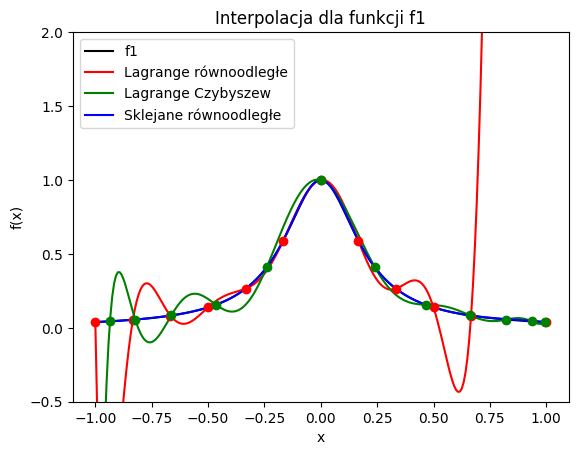

In [54]:
plt.ylim(-0.5,2)
plt.plot(x_space,[f1(x) for x in x_space],color="black", label="f1")
plt.plot(x_space,y_eqdist_lag, color="r", label="Lagrange równoodległe")
plt.plot(x_space,y_cheb_lag, color="g", label="Lagrange Czybyszew")
plt.plot(x_space,cs(x_space),color="b", label="Sklejane równoodległe")
plt.plot(x_eq, f1(x_eq), 'o', color='r')
plt.plot(x_ch, f1(x_ch), 'o', color='g')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("Interpolacja dla funkcji f1")

Możemy zauważyć dla wielomianu interpolacyjnego Lagrange'a bardzo złe dopasowanie wielomianu w pomiędzy skrajnymi węzłami interpolacyjnymi. Dla węzłów Czebyszewa efekt ten również zachodzi lecz znacznie mniejszym stopniu - zmniejszenie odległości pomiędzy skrajnymi punktami interpolacji trochę poprawiło dopasowanie wielomianu pomiędzy tymi punktami. Najlepiej dopasowanym wielomianem interpolacyjnym okazał się wielomian stworzony przy pomocy kubicznych funkcji sklejanych, na wykresie praktycznie pokrywa się z prawdziwą funkcją.

Zadanie b) 

Na początku tworzymy wektory błędów dla każdej z interpolacji

In [55]:
err1 = np.empty(47)
err2 = np.empty(47)
err3 = np.empty(47)

err_eqdist_lag = np.empty(500)
err_cheb_lag = np.empty(500)
err_cs = np.empty(500)

Następnie generujemy 500 losowych punktów z przedziału (-1, 1)

In [56]:
x_set = np.empty(500)
for j in range(500):
    x_set[j] = uniform(-1,1)

Dla ilości węzłów interpolacji n = 4,5,...,50 kolejno obliczamy wielomiany interpolacyjne oraz wektory błędów bezwględnych dla każdego wielomianu

In [57]:
for i in range(4,51):
    x_eq = get_eqdist(i,-1,1)
    y_eq = [f1(x) for x in x_eq] # exact values in Lagrange interpolation nodes

    x_ch = transform_cheb(get_nodes_cheb(i), -1, 1)
    y_ch = [f1(x) for x in x_ch] # exact values in Chebyshow interpolation nodes

    y_eqdist_lag = [lagrange_polynomial(x_eq,y_eq,x) for x in x_set] # Lagrange polynomial
    y_cheb_lag = [lagrange_polynomial(x_ch,y_ch,x) for x in x_set] # Chebyshow
    cs = interpolate.CubicSpline(x_eq,y_eq)
    y_cs = [cs(x) for x in x_set] # cubic splines

    for j in range(500):
        err_eqdist_lag[j] = abs(y_eqdist_lag[j] - f1(x_set[j]))
        err_cheb_lag[j] = abs(y_cheb_lag[j] - f1(x_set[j]))
        err_cs[j] = abs(y_cs[j] - f1(x_set[j]))
    
    err1[i-4] = np.linalg.norm(err_eqdist_lag)
    err2[i-4] = np.linalg.norm(err_cs)
    err3[i-4] = np.linalg.norm(err_cheb_lag)

Następnie rysujemy punktowy wykres błędu dla każdego z wielomianów w skali logarytmicznej

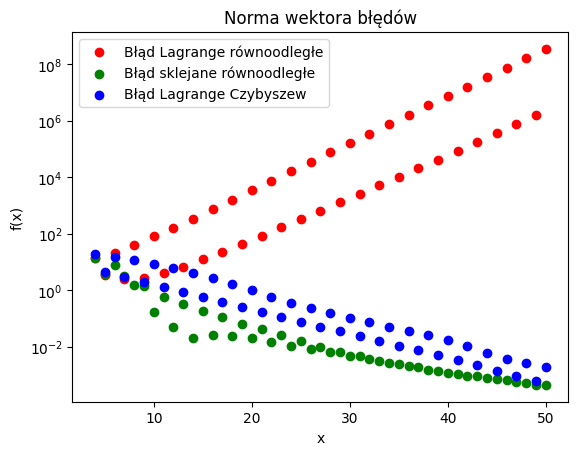

In [58]:
plt.semilogy()
plt.scatter([i for i in range(4, 51)], err1, color='r', label="Błąd Lagrange równoodległe")
plt.scatter([i for i in range(4, 51)], err2, color='g', label="Błąd sklejane równoodległe")
plt.scatter([i for i in range(4, 51)], err3, color='b',label="Błąd Lagrange Czybyszew")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Norma wektora błędów dla interpolacji funkcji f1")
plt.legend()

Na wykresie można zauważyć, że wraz ze wzrostem ilości węzłów interpolacji, błąd dla równoodległych węzłów i metody Lagrange'a również rośnie wykładniczo, zachodzi tutaj efekt Rungego. W przypadku dwóch pozostałych wielomianów oba wraz ze wzrostem liczby węzłów zwiększają swoją dokładność, jednak funkcje sklejane dla tej konkretnej funckji są bardziej dokładne

Generujemy analogiczny wykres dla drugiej funkcji:

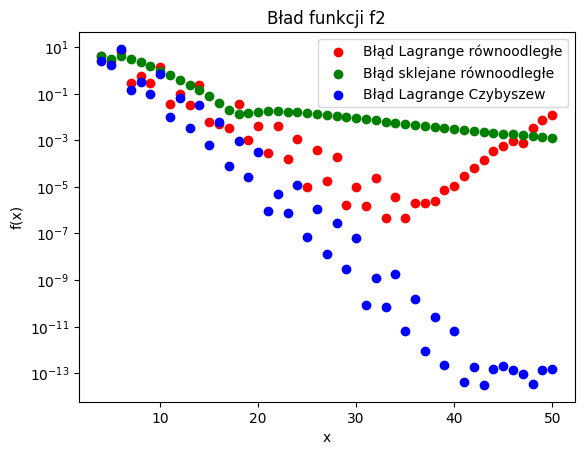

In [59]:
err1 = np.empty(47)
err2 = np.empty(47)
err3 = np.empty(47)
err_eqdist_lag = np.empty(500)
err_cheb_lag = np.empty(500)
err_cs = np.empty(500)
x_set = np.empty(500)
for j in range(500):
    x_set[j] = uniform(0,2*mp.pi)
for i in range(4,51):
    x_eq = get_eqdist(i,0, 2*mp.pi)
    y_eq = [f2(x) for x in x_eq]
    x_ch = transform_cheb(get_nodes_cheb(i), 0, 2*mp.pi)
    y_ch = [f2(x) for x in x_ch]
    y_eqdist_lag = [lagrange_polynomial(x_eq,y_eq,x) for x in x_set]
    y_cheb_lag = [lagrange_polynomial(x_ch,y_ch,x) for x in x_set]
    cs = interpolate.CubicSpline(x_eq,y_eq)
    y_cs = [cs(x) for x in x_set]

    for j in range(500):
        err_eqdist_lag[j] = abs(y_eqdist_lag[j] - f2(x_set[j]))
        err_cheb_lag[j] = abs(y_cheb_lag[j] - f2(x_set[j]))
        err_cs[j] = abs(y_cs[j] - f2(x_set[j]))
    err1[i-4] = np.linalg.norm(err_eqdist_lag)
    err2[i-4] = np.linalg.norm(err_cs)
    err3[i-4] = np.linalg.norm(err_cheb_lag)
plt.semilogy()
plt.scatter([i for i in range(4, 51)], err1, color='r', label="Błąd Lagrange równoodległe")
plt.scatter([i for i in range(4, 51)], err2, color='g', label="Błąd sklejane równoodległe")
plt.scatter([i for i in range(4, 51)], err3, color='b', label="Błąd Lagrange Czybyszew")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Norma wektora błędów dla interpolacji funkcji f2")
plt.legend()

W tym przypadku bezkonkurencyjnie wygrywa interpolacja przy użyciu węzłów Czebyszewa. Równoodległe punkty w interpolacji Lagrange'a do pewnego momentu dają bardzo dobre wyniki, niestety od n = 35 pojawia się efekt Rungego i błąd zaczyna rosnąć. Jesteśmy w stanie znaleźć takie n, dla którego błąd będzie najmniejszy i porównując go z błędem interpolacji dla funkcji sklejanych jest on stosunkowo mały.

# Wnioski

Analizując dwa powyższe przykłady, dochodzimy do wniosku, że w ogólnym przypadku interpolacja Lagrange'a przy użyciu węzłów Czebyszewa daje najlepsze efekty, niemalże zawsze lepsze niż dla punktów równoodległych. Jednak warto czasem rozważyć użycie funkcji sklejanych, ponieważ jak możemy zobaczyć w podpunkcie a), dla konkretnej funkcji i konkretnej ilości węzłów interpolacji, możemy dzięki nim uzyskać bardzo dokładne wyniki.